In [30]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client
client = Client(tld='us')

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

In [31]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
r = client.get_historical_klines('BTCUSDT','5m',startDate)

In [32]:
df = pd.DataFrame(r)
colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)
df['predict'] = 1
df.set_index("closeTime", inplace= True)
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict
closeTime,,,,,,,,,,,,,,
2022-01-01 00:04:59.999,1640995200000,46192.43,46377.56,46192.43,46317.57,5.050394,233839.23426489,114,3.61709700,167437.16632386,0,NaN,0.000568,1
2022-01-01 00:09:59.999,1640995500000,46303.29,46502.74,46283.94,46343.89,1.726150,80140.26585505,101,1.13397100,52671.64021728,0,0.000568,-0.000089,1


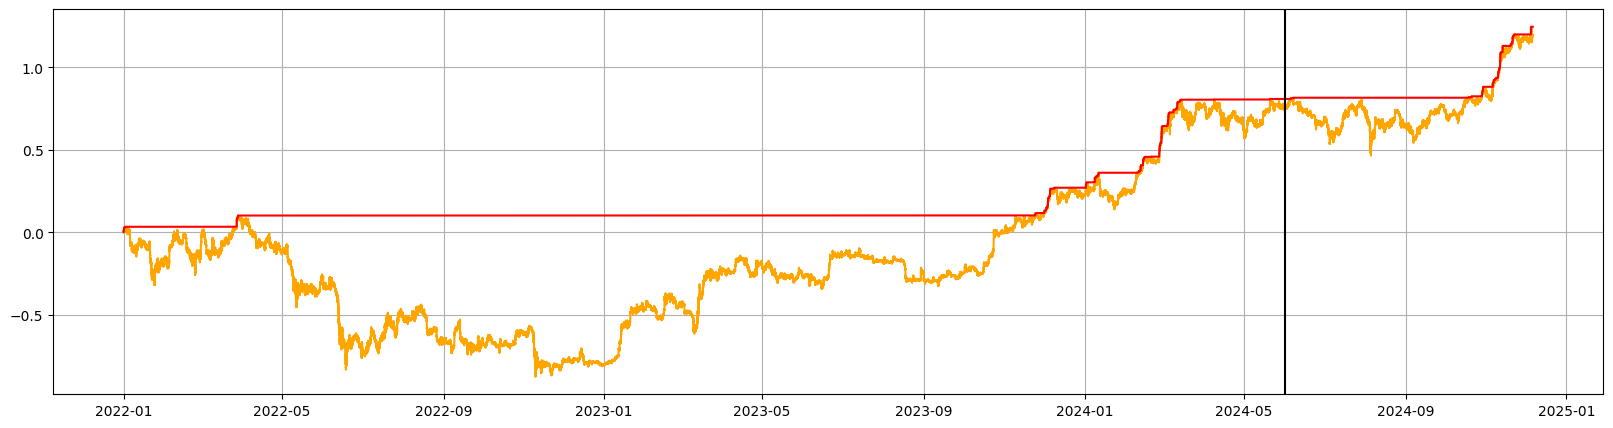

In [33]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [34]:
def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe   : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train

In [35]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)

    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.

    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/

    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal

        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
            Histogram = MA

In [36]:
df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
closeTime,,,
2022-01-01 00:04:59.999,NaN,NaN,NaN
2022-01-01 00:09:59.999,NaN,NaN,NaN
2022-01-01 00:14:59.999,NaN,NaN,NaN
2022-01-01 00:19:59.999,NaN,NaN,NaN
2022-01-01 00:24:59.999,NaN,NaN,NaN
...,...,...,...
2024-12-06 11:44:59.999,-22.546468,-5.873955,-16.672513
2024-12-06 11:49:59.999,-22.355542,-4.546424,-17.809119
2024-12-06 11:54:59.999,-13.194612,3.691606,-16.886217


In [37]:
columns_to_convert = ['quoteAssetVolume', 'TakerBaseVolume', 'TakerQuoteVolume', 'Ignore']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [38]:
def func_features(df):
    for length in [6, 12, 16, 20, 25, 30, 50]:
        # Simple Moving Average (SMA) and related signal
        df.ta(kind='SMA', append=True, centered=False, close='closePrice', length=length)
        df[f'f_SMA_{length}'] = np.where(df['closePrice'] > df[f'SMA_{length}'], -1, 1)

        # Trend-based feature using rolling returns
        df[f'f_trend_{length}'] = np.where(df['return'].rolling(window=length).sum() > 0, -1, 1)

        # Average True Range (ATR)
        df.ta(kind='ATR', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=length)
        df[f'f_ATR_{length}'] = np.where(df[f'ATRr_{length}'] > df[f'ATRr_{length}'].rolling(window=6).mean(), 1, -1)

        # Relative Strength Index (RSI)
        df.ta(kind='RSI', append=True, centered=False, close='closePrice', length=length)
        df[f'f_RSI_{length}'] = np.where(df[f'RSI_{length}'] < 20, 1, np.where(df[f'RSI_{length}'] > 80, -1, 0))

        # Price Volume Trend (PVT)
        df.ta(kind='PVT', append=True, centered=False, volume='volume', close='closePrice')
        df[f'f_PVT_{length}'] = np.where(df['PVT'] > df['PVT'].rolling(window=length).mean(), 1, -1)

        # Bollinger Bands
        df.ta(kind='BBANDS', append=True, centered=False, close='closePrice', length=length)
        df[f'f_bb_{length}_low'] = np.where(df['closePrice'] < df[f'BBL_{length}_2.0'], 1, 0)
        df[f'f_bb_{length}_high'] = np.where(df['closePrice'] > df[f'BBU_{length}_2.0'], -1, 0)

    # Moving Average Convergence Divergence (MACD)
    df.ta(kind='MACD', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_macd'] = np.where(df['MACDh_12_26_9'] > 0, 1, -1)

    # On-Balance Volume (OBV)
    df.ta(kind='OBV', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_OBV'] = np.where(df['OBV'] < df['OBV'].rolling(window=12).mean(), -1, 1)

    # Momentum Indicator (MOM)
    df.ta(kind='MOM', append=True, centered=False, close='closePrice', length=10)
    df['f_momentum'] = np.where(df['MOM_10'] > 0, 1, -1)

    # Additional features
    df['f_high'] = df['highPrice'].pct_change().fillna(0)
    df['f_low'] = df['lowPrice'].pct_change().fillna(0)
    df['f_high_low'] = (df['highPrice'] - df['lowPrice']) / (df['highPrice'] + df['lowPrice']).fillna(0)
    df['f_open_close'] = (df['openPrice'] - df['closePrice']) / (df['openPrice'] + df['closePrice']).fillna(0)
    df['f_ntv'] = df['NumberOfTrades'].pct_change().where(df['NumberOfTrades'].pct_change() != np.inf, np.nan).ffill().fillna(0)
    df['f_taker_volume_ratio'] = (df['TakerBaseVolume'] / df['volume']).fillna(0)
    df['f_rolling_std'] = df['closePrice'].rolling(window=20).std().fillna(0)

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f'lag_return_{lag}'] = df['return'].shift(lag)

    # Feature engineering for targets
    df['return_next_class'] = np.where(df['return_next'] > 0, 1, 0)

    return df

In [39]:
df = func_features(df)

C:\Users\Mirom\AppData\Local\Temp\ipykernel_3808\1168149345.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_train = round(pnl_train/mdd_train,6)


            train     test
PNL      : 132.217992 2.275467  
MDD      : 0.0        0.18971   
Sharpe   : inf        11.994449 


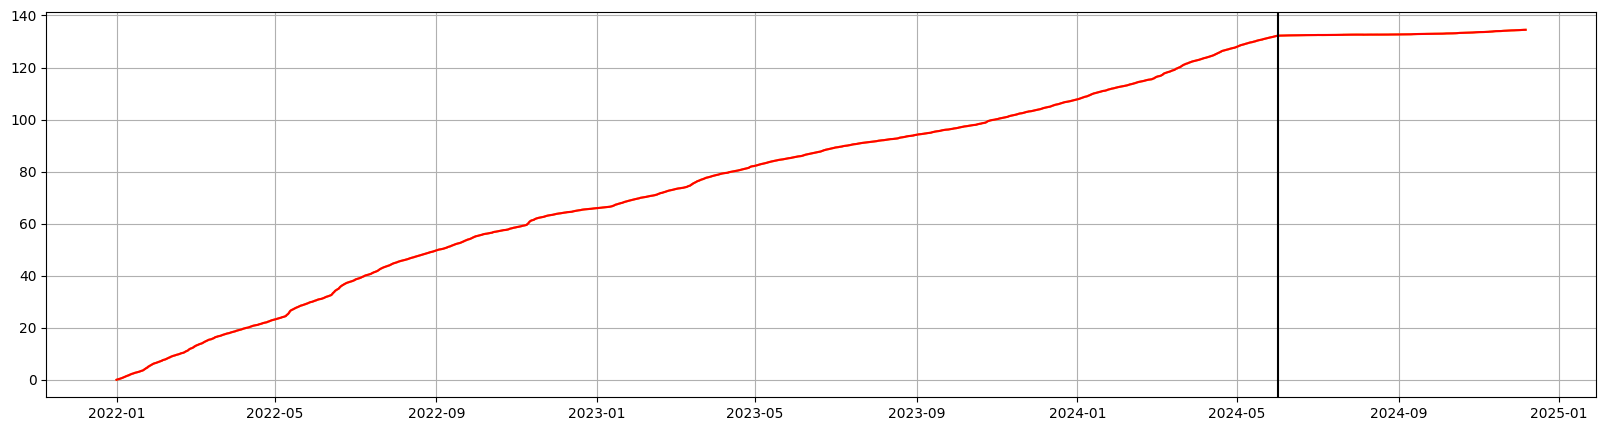

In [40]:
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def func_train_model(modelType,df,testDate):

  if modelType == 'rf':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next_class']

    model = Pipeline([
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
      ('classification', RandomForestClassifier())
    ])
    model.fit(X_train, y_train)

    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'cb':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = CatBoostRegressor(iterations=1000, loss_function='RMSE',depth=7, verbose=False, early_stopping_rounds=10, random_seed=1)
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'cb_gs':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    cat = CatBoostRegressor(verbose=False)
    params = {'iterations':[1000],
          #'depth':[5,10]
          'l2_leaf_reg': np.logspace(-20,-10,3),
          'early_stopping_rounds':[10]
          }
    model = GridSearchCV(estimator=cat,cv=5,param_grid=params)
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'cb_w':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']

    sample_weight = np.array([0])
    dfLength = len(X_train)
    rowWeigth = 0
    for i in range(dfLength-1):
      sample_weight = np.append(sample_weight, rowWeigth)
      rowWeigth = rowWeigth + 1/dfLength

    model = CatBoostRegressor(iterations=1000, loss_function='RMSE',depth=7, verbose=False, early_stopping_rounds=10, random_seed=1)
    model.fit(X_train,y_train,sample_weight=sample_weight)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'lr':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'lr_sl':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
    df['pnl'] = (df['predict'] * df['return_next']).shift(1)
    df['predict'] = np.where(df['pnl'].rolling(window=100).sum()<0,0.5 * df['predict'], df['predict'])

  if modelType == 'lr_ig':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']

    #mutual_info = mutual_info_regression(X_train,y_train)
    #mutual_info = pd.Series(mutual_info)
    #mutual_info.index = features
    #mutual_info.sort_values(ascending=False)

    bestCols =  SelectKBest(mutual_info_regression,k=10)
    bestCols.fit(X_train,y_train)
    features = list(X_train.columns[bestCols.get_support()])

    X_train = train[features]
    model = LinearRegression()
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'lr_rfe':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    reg = LinearRegression()
    model = RFE(reg, n_features_to_select=15)
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  if modelType == 'lr_reg':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = Ridge(alpha=1.0)
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  if modelType == 'lr_cor':
    features = [col for col in df if col.startswith('f_')]
    corr_matrix = df[features].corr().abs()
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k =1).astype(np.bool_))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
    features = [f for f in features if f not in to_drop]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  if modelType == 'dt':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next_class']
    model = DecisionTreeClassifier(random_state=0,max_depth=5)
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  if modelType == 'elnet_cv':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    alpha = [0.0001,0.001,0.1,1,10,100]
    max_iter = [1000,10000]
    l1_ratio = np.arange(0.0,1.0,0.1)
    tol=[0.5]
    elnet_gscv = GridSearchCV(estimator=ElasticNet(),param_grid={'alpha':alpha,'max_iter':max_iter,'l1_ratio':l1_ratio,'tol':tol}, scoring='r2',cv=5)
    elnet_gscv.fit(X_train,y_train)
    model = ElasticNet(alpha = elnet_gscv.best_params_['alpha'],
                      max_iter = elnet_gscv.best_params_['max_iter'],
                      l1_ratio = elnet_gscv.best_params_['l1_ratio'],
                      tol = elnet_gscv.best_params_['tol'])
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  if modelType == 'elnet':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = ElasticNet()
    model.fit(X_train,y_train)
    df['predict'] = model.predict(df[features])
    df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))

  df['pnl'] = df['predict'] * df['return_next']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  return df
df = func_train_model('rf',df,testDate)
sharpe = func_model_performance(df)
func_plot(df)

In [41]:
for model_type in ["lr","dt","lr_reg","lr_cor","lr_rfe","elnet","lr_ig","rf"]:
  print('----------',model_type,'----------')
  df = func_features(df)
  df = func_train_model(model_type,df,testDate)
  sharpe = func_model_performance(df)


---------- lr ----------
            train     test
PNL      : 11.703064  6.680917  
MDD      : 0.22827    0.153555  
Sharpe   : 51.268515  43.5083   
---------- dt ----------
            train     test
PNL      : 6.285414   3.755397  
MDD      : 0.393048   0.196821  
Sharpe   : 15.991467  19.080266 
---------- lr_reg ----------
            train     test
PNL      : 10.204441  4.933413  
MDD      : 0.317015   0.185396  
Sharpe   : 32.189142  26.610137 
---------- lr_cor ----------
            train     test
PNL      : 11.984641  7.361963  
MDD      : 0.270452   0.169712  
Sharpe   : 44.313375  43.379154 
---------- lr_rfe ----------
            train     test
PNL      : 11.288004  7.556355  
MDD      : 0.203163   0.173882  
Sharpe   : 55.561318  43.456798 
---------- elnet ----------
            train     test
PNL      : 0.753559   0.439216  
MDD      : 0.977612   0.35066   
Sharpe   : 0.770816   1.252541  
---------- lr_ig ----------
            train     test
PNL      : 11.222495  8.

C:\Users\Mirom\AppData\Local\Temp\ipykernel_3808\1168149345.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_train = round(pnl_train/mdd_train,6)


In [42]:
import optuna
from functools import partial
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

def objective(trial, testDate=testDate, df=df):

  #length_rsi = int(trial.suggest_categorical("length_rsi",["6","12","18","24","30","36"]))
  #length_pvt = int(trial.suggest_categorical("length_pvt",["6","12","18","24","30","36"]))
  model_type = trial.suggest_categorical("model_type",["lr","dt","lr_reg","lr_cor","lr_rfe","elnet","lr_ig","rf"])
  #model_type = trial.suggest_categorical("model_type",["cb","cb_w"])

  df = func_features(df)
  df = func_train_model(model_type,df,testDate)
  sharpe = func_model_performance(df)

  return sharpe

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 20, timeout = 1000, show_progress_bar = True)

[I 2024-12-06 15:24:05,303] A new study created in memory with name: no-name-cd0dc75e-d3df-4807-a71d-d445e577a5af


Best trial: 0. Best value: 15.9915:   5%|▌         | 1/20 [00:19<06:07, 19.35s/it, 19.34/1000 seconds]

            train     test
PNL      : 6.285414   3.755397  
MDD      : 0.393048   0.196821  
Sharpe   : 15.991467  19.080266 
[I 2024-12-06 15:24:24,664] Trial 0 finished with value: 15.991467 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 15.991467.


Best trial: 1. Best value: 44.3134:  10%|█         | 2/20 [00:41<06:13, 20.76s/it, 41.10/1000 seconds]

            train     test
PNL      : 11.984641  7.361963  
MDD      : 0.270452   0.169712  
Sharpe   : 44.313375  43.379154 
[I 2024-12-06 15:24:46,424] Trial 1 finished with value: 44.313375 and parameters: {'model_type': 'lr_cor'}. Best is trial 1 with value: 44.313375.


C:\Users\Mirom\AppData\Local\Temp\ipykernel_3808\1168149345.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_train = round(pnl_train/mdd_train,6)
Best trial: 2. Best value: inf:  15%|█▌        | 3/20 [04:49<35:21, 124.80s/it, 289.70/1000 seconds]  

            train     test
PNL      : 132.217992 2.463841  
MDD      : 0.0        0.188957  
Sharpe   : inf        13.039162 
[I 2024-12-06 15:28:55,021] Trial 2 finished with value: inf and parameters: {'model_type': 'rf'}. Best is trial 2 with value: inf.


C:\Users\Mirom\AppData\Local\Temp\ipykernel_3808\1168149345.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_train = round(pnl_train/mdd_train,6)
Best trial: 2. Best value: inf:  20%|██        | 4/20 [08:06<40:48, 153.04s/it, 486.04/1000 seconds]

            train     test
PNL      : 132.217992 2.201705  
MDD      : 0.0        0.148688  
Sharpe   : inf        14.80755  
[I 2024-12-06 15:32:11,368] Trial 3 finished with value: inf and parameters: {'model_type': 'rf'}. Best is trial 2 with value: inf.


Best trial: 2. Best value: inf:  25%|██▌       | 5/20 [08:11<24:57, 99.83s/it, 491.52/1000 seconds] 

            train     test
PNL      : 6.285414   3.755397  
MDD      : 0.393048   0.196821  
Sharpe   : 15.991467  19.080266 
[I 2024-12-06 15:32:16,855] Trial 4 finished with value: 15.991467 and parameters: {'model_type': 'dt'}. Best is trial 2 with value: inf.


Best trial: 2. Best value: inf:  30%|███       | 6/20 [11:30<31:10, 133.63s/it, 690.78/1000 seconds]

            train     test
PNL      : 11.222495  8.00875   
MDD      : 0.37311    0.144801  
Sharpe   : 30.078248  55.308665 
[I 2024-12-06 15:35:36,108] Trial 5 finished with value: 30.078248 and parameters: {'model_type': 'lr_ig'}. Best is trial 2 with value: inf.


Best trial: 2. Best value: inf:  35%|███▌      | 7/20 [11:33<19:41, 90.89s/it, 693.68/1000 seconds] 

            train     test
PNL      : 0.753559   0.439216  
MDD      : 0.977612   0.35066   
Sharpe   : 0.770816   1.252541  
[I 2024-12-06 15:35:38,997] Trial 6 finished with value: 0.770816 and parameters: {'model_type': 'elnet'}. Best is trial 2 with value: inf.


C:\Users\Mirom\AppData\Local\Temp\ipykernel_3808\1168149345.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_train = round(pnl_train/mdd_train,6)
Best trial: 2. Best value: inf:  40%|████      | 8/20 [13:47<20:52, 104.41s/it, 827.02/1000 seconds]

            train     test
PNL      : 132.217992 2.350416  
MDD      : 0.0        0.203208  
Sharpe   : inf        11.566552 
[I 2024-12-06 15:37:52,348] Trial 7 finished with value: inf and parameters: {'model_type': 'rf'}. Best is trial 2 with value: inf.


Best trial: 2. Best value: inf:  45%|████▌     | 9/20 [14:11<14:32, 79.28s/it, 851.03/1000 seconds] 

            train     test
PNL      : 11.288004  7.556355  
MDD      : 0.203163   0.173882  
Sharpe   : 55.561318  43.456798 
[I 2024-12-06 15:38:16,364] Trial 8 finished with value: 55.561318 and parameters: {'model_type': 'lr_rfe'}. Best is trial 2 with value: inf.


Best trial: 2. Best value: inf:  50%|█████     | 10/20 [18:18<18:18, 109.86s/it, 1098.61/1000 seconds]

            train     test
PNL      : 11.222495  8.00875   
MDD      : 0.37311    0.144801  
Sharpe   : 30.078248  55.308665 
[I 2024-12-06 15:42:23,941] Trial 9 finished with value: 30.078248 and parameters: {'model_type': 'lr_ig'}. Best is trial 2 with value: inf.


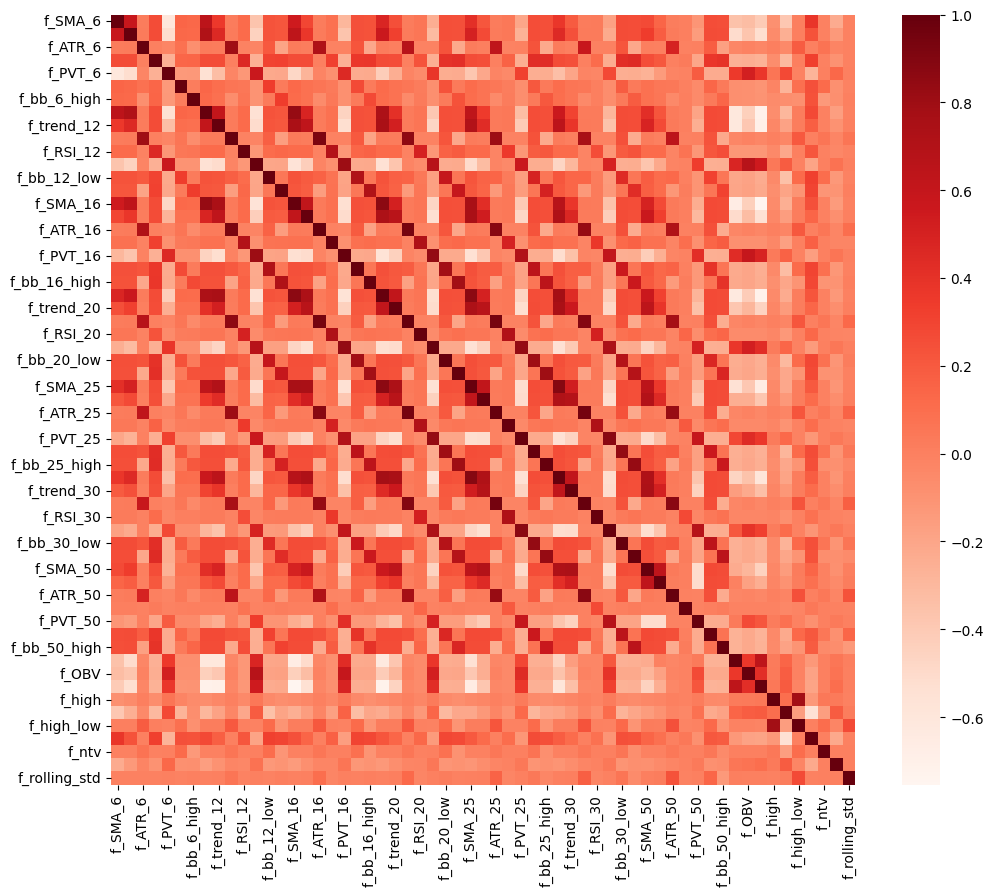

In [43]:
import seaborn as sns
features = [col for col in df if col.startswith('f_')]
plt.figure(figsize=(12,10))
cor = df[features].corr()
sns.heatmap(cor,annot=False, cmap=plt.cm.Reds)
plt.show()